In [170]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import ADASYN
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

In [171]:
path = os.getcwd() + '/data/data.csv'
df = pd.read_csv(path)

In [172]:
df.columns

Index(['Name', 'Address', 'Latitude', 'Longitude', 'Supply_type',
       'Applicant_type', 'Units', 'Gender', 'Shared', 'Cutline_rate',
       'Cutline_score', 'Year', 'Quarter', 'Applied_type', 'Counts_daiso',
       'Counts_supermarket', 'Counts_laundry', 'Counts_pharmacy',
       'Counts_cafe', 'Counts_convstore', 'Counts_station', 'Infra_score',
       'people', 'Rate1', 'Rate2', 'Rate3'],
      dtype='object')

In [173]:
df[['gu', 'ro']] = df['Address'].str.split(' ', expand=True).iloc[:, :2]
df['Supply_type'] = df['Supply_type'].str.replace(r'\D', '', regex=True)

df.drop(
    columns=[
        'Name','Address', 'Latitude', 'Longitude', 'Infra_score',
        'Gender','Shared','Quarter','Counts_supermarket','Counts_laundry',
        'Counts_pharmacy'
    ],
    inplace=True
)

cutline_rate = df['Cutline_rate']
df = pd.get_dummies(df.drop(columns=['Cutline_rate']))
df['Cutline_rate'] = cutline_rate

X = df.drop(columns=['Cutline_rate'])
X = X.astype('float32')
y = df['Cutline_rate']
y = y.astype('float32')


In [174]:
X.shape

(876, 341)

In [175]:
adasyn = ADASYN(random_state=42)
X_s, y_s = adasyn.fit_resample(X, y)

print("오버샘플링 전 클래스 분포:", Counter(y))
print("오버샘플링 후 클래스 분포:", Counter(y_s))

오버샘플링 전 클래스 분포: Counter({1.0: 573, 2.0: 269, 3.0: 34})
오버샘플링 후 클래스 분포: Counter({3.0: 574, 1.0: 573, 2.0: 526})


In [176]:
X = X_s.copy()
y_classification = y_s.copy()
y_regression = X_s['Cutline_score']

In [177]:
X.select_dtypes(include='object').columns

Index([], dtype='object')

In [178]:
X_train, X_test, y_train_classification, y_test_classification, y_train_regression, y_test_regression = train_test_split(X, y_classification, y_regression, test_size=0.1, random_state=42)

In [179]:
X_train.select_dtypes(include='object').columns

Index([], dtype='object')

In [180]:
X_train.values

array([[0.7418666, 8.420802 , 2.7744002, ..., 0.       , 0.       ,
        0.       ],
       [0.       , 4.       , 7.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 3.912096 , 4.329677 , ..., 0.       , 0.       ,
        0.       ],
       ...,
       [0.       , 1.       , 3.       , ..., 0.       , 0.       ,
        0.       ],
       [1.       , 8.211802 , 2.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 8.745401 , 7.0563035, ..., 0.       , 0.       ,
        0.       ]], dtype=float32)

# 데이터 스케일링
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [181]:
y_train_classification = y_train_classification - 1
y_test_classification = y_test_classification - 1

In [182]:
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_classification_tensor = torch.tensor(y_train_classification.values, dtype=torch.long)
y_test_classification_tensor = torch.tensor(y_test_classification.values, dtype=torch.long)
y_train_regression_tensor = torch.tensor(y_train_regression.values, dtype=torch.float32)
y_test_regression_tensor = torch.tensor(y_test_regression.values, dtype=torch.float32)


class MultiOutputNN(nn.Module):
    def __init__(self, input_dim):
        super(MultiOutputNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 256)
        self.fc4 = nn.Linear(256, 128)
        self.classification_head = nn.Linear(128, 3)
        self.regression_head = nn.Linear(128, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        classification_output = self.classification_head(x)
        regression_output = self.regression_head(x)
        return classification_output, regression_output

In [183]:
model = MultiOutputNN(input_dim=X_train.shape[1])

In [184]:
classification_loss_fn = nn.CrossEntropyLoss()
regression_loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

best_loss = float('inf')
patience = 15
patience_counter = 0

num_epochs = 100
batch_size = 1

train_losses_classification = []
train_losses_regression = []
val_losses_classification = []
val_losses_regression = []

In [185]:
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    
    # Forward pass
    classification_output, regression_output = model(X_train_tensor)
    
    # Compute losses
    classification_loss = classification_loss_fn(classification_output, y_train_classification_tensor)
    regression_loss = regression_loss_fn(regression_output.squeeze(), y_train_regression_tensor)
    total_loss = classification_loss + regression_loss
    
    # Backward pass and optimization
    total_loss.backward()
    optimizer.step()
    
    train_losses_classification.append(classification_loss.item())
    train_losses_regression.append(regression_loss.item())
    
    # Validation
    model.eval()
    with torch.no_grad():
        classification_output_val, regression_output_val = model(X_test_tensor)
        val_classification_loss = classification_loss_fn(classification_output_val, y_test_classification_tensor)
        val_regression_loss = regression_loss_fn(regression_output_val.squeeze(), y_test_regression_tensor)
        
        val_losses_classification.append(val_classification_loss.item())
        val_losses_regression.append(val_regression_loss.item())
    
    # Early stopping
    if val_classification_loss.item() + val_regression_loss.item() < best_loss:
        best_loss = val_classification_loss.item() + val_regression_loss.item()
        patience_counter = 0
    else:
        patience_counter += 1
    
    if patience_counter >= patience:
        print(f"Early stopping at epoch {epoch}")
        break

# Evaluate the model
model.eval()
with torch.no_grad():
    classification_output_test, regression_output_test = model(X_test_tensor)
    _, predicted_classification = torch.max(classification_output_test, 1)
    
    # Compute metrics
    classification_accuracy = (predicted_classification == y_test_classification_tensor).float().mean()
    regression_mae = torch.mean(torch.abs(regression_output_test.squeeze() - y_test_regression_tensor))
    
    print(f"Classification Accuracy: {classification_accuracy.item()}")
    print(f"Regression MAE: {regression_mae.item()}")

Classification Accuracy: 0.601190447807312
Regression MAE: 1.599764347076416


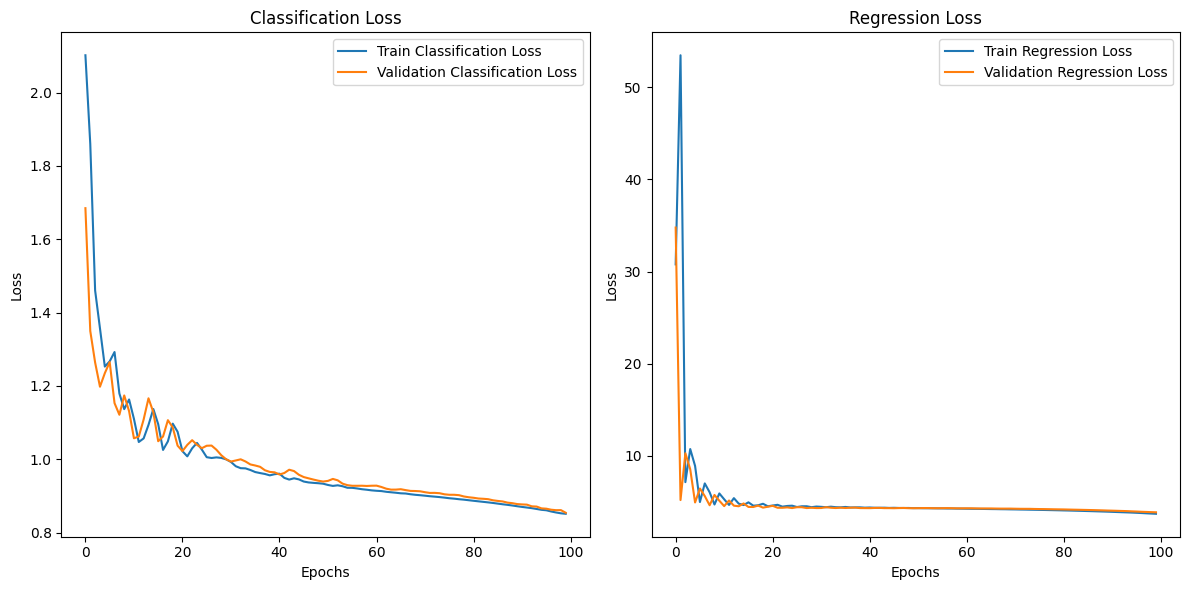

In [186]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(train_losses_classification, label='Train Classification Loss')
plt.plot(val_losses_classification, label='Validation Classification Loss')
plt.title('Classification Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_losses_regression, label='Train Regression Loss')
plt.plot(val_losses_regression, label='Validation Regression Loss')
plt.title('Regression Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()